# Face Generation

In this project, you'll define and train a DCGAN on a dataset of faces. Your goal is to get a generator network to generate *new* images of faces that look as realistic as possible!

The project will be broken down into a series of tasks from **loading in data to defining and training adversarial networks**. At the end of the notebook, you'll be able to visualize the results of your trained Generator to see how it performs; your generated samples should look like fairly realistic faces with small amounts of noise.

### Get the Data

You'll be using the [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) to train your adversarial networks.

This dataset is more complex than the number datasets (like MNIST or SVHN) you've been working with, and so, you should prepare to define deeper networks and train them for a longer time to get good results. It is suggested that you utilize a GPU for training.

### Pre-processed Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. Some sample data is show below.

<img src='assets/processed_face_data.png' width=60% />

> If you are working locally, you can download this data [by clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip)

This is a zip file that you'll need to extract in the home directory of this notebook for further loading and processing. After extracting the data, you should be left with a directory of data `processed_celeba_small/`

In [30]:
# can comment out after executing
#!unzip processed_celeba_small.zip

In [31]:
data_dir = 'processed_celeba_small/'

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import problem_unittests as tests
#import helper

%matplotlib inline

## Visualize the CelebA Data

The [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations. Since you're going to be generating faces, you won't need the annotations, you'll only need the images. Note that these are color images with [3 color channels (RGB)](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images) each.

### Pre-process and Load the Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. This *pre-processed* dataset is a smaller subset of the very large CelebA data.

> There are a few other steps that you'll need to **transform** this data and create a **DataLoader**.

#### Exercise: Complete the following `get_dataloader` function, such that it satisfies these requirements:

* Your images should be square, Tensor images of size `image_size x image_size` in the x and y dimension.
* Your function should return a DataLoader that shuffles and batches these Tensor images.

#### ImageFolder

To create a dataset given a directory of images, it's recommended that you use PyTorch's [ImageFolder](https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder) wrapper, with a root directory `processed_celeba_small/` and data transformation passed in.

In [32]:
# necessary imports
import torch
from torchvision import datasets
from torchvision import transforms

In [33]:
from torch.utils.data import DataLoader
def get_dataloader(batch_size, image_size, data_dir='processed_celeba_small/'):
    """
    Batch the neural network data using DataLoader
    :param batch_size: The size of each batch; the number of images in a batch
    :param img_size: The square size of the image data (x, y)
    :param data_dir: Directory where image data is located
    :return: DataLoader with batched data
    """
    
    # TODO: Implement function and return a dataloader
    transform = transforms.Compose([transforms.Resize(image_size), transforms.ToTensor()])
    dataset = datasets.ImageFolder(data_dir, transform)
    dataloader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    return dataloader


## Create a DataLoader

#### Exercise: Create a DataLoader `celeba_train_loader` with appropriate hyperparameters.

Call the above function and create a dataloader to view images. 
* You can decide on any reasonable `batch_size` parameter
* Your `image_size` **must be** `32`. Resizing the data to a smaller size will make for faster training, while still creating convincing images of faces!

In [34]:
# Define function hyperparameters
batch_size = 64
img_size = 32

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Call your function and get a dataloader
celeba_train_loader = get_dataloader(batch_size, img_size)


Next, you can view some images! You should seen square images of somewhat-centered faces.

Note: You'll need to convert the Tensor images into a NumPy type and transpose the dimensions to correctly display an image, suggested `imshow` code is below, but it may not be perfect.

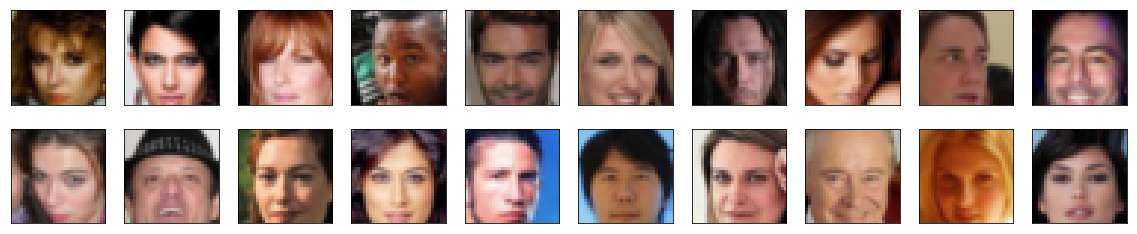

In [35]:
# helper display function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# obtain one batch of training images
dataiter = iter(celeba_train_loader)
images, _ = dataiter.next() # _ for no labels

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

#### Exercise: Pre-process your image data and scale it to a pixel range of -1 to 1

You need to do a bit of pre-processing; you know that the output of a `tanh` activated generator will contain pixel values in a range from -1 to 1, and so, we need to rescale our training images to a range of -1 to 1. (Right now, they are in a range from 0-1.)

In [36]:
# TODO: Complete the scale function
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    # assume x is scaled to (0, 1)
    # scale to feature_range and return scaled x
    min, max = feature_range
    x = x * (max - min) + min
    return x


In [37]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# check scaled range
# should be close to -1 to 1
img = images[0]
scaled_img = scale(img)

print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

Min:  tensor(-1.)
Max:  tensor(0.7725)


---
# Define the Model

A GAN is comprised of two adversarial networks, a discriminator and a generator.

## Discriminator

Your first task will be to define the discriminator. This is a convolutional classifier like you've built before, only without any maxpooling layers. To deal with this complex data, it's suggested you use a deep network with **normalization**. You are also allowed to create any helper functions that may be useful.

#### Exercise: Complete the Discriminator class
* The inputs to the discriminator are 32x32x3 tensor images
* The output should be a single value that will indicate whether a given image is real or fake


In [38]:
import torch.nn as nn
import torch.nn.functional as F

In [39]:
def conv(in_channels, out_channels, kernel_size, stride=1, padding=1, batch_norm=True):
    layers = []
    conv_layer = nn.Conv2d(in_channels, out_channels, 
                           kernel_size, stride, padding, bias=False)

    layers.append(conv_layer)

    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))

    return nn.Sequential(*layers)

In [40]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim):
        """
        Initialize the Discriminator Module
        :param conv_dim: The depth of the first convolutional layer
        """
        super(Discriminator, self).__init__()
        
        # complete init function
        
        self.conv_dim = conv_dim
        
        self.conv1 = conv(3, conv_dim, 4, batch_norm=False, stride=2)
        
        #self.conv1_1=conv(conv_dim, conv_dim, 3)
        #self.conv1_2=conv(conv_dim, conv_dim, 3)
        
        self.conv2 = conv(conv_dim, conv_dim*2, 4, stride=2)
        
        #self.conv2_1=conv(conv_dim*2, conv_dim*2, 3)
        #self.conv2_2=conv(conv_dim*2, conv_dim*2, 3)
        
        self.conv3 = conv(conv_dim*2, conv_dim*4, 4, stride=2)
        
        #self.conv3_1=conv(conv_dim*4, conv_dim*4, 3)
        #self.conv3_2=conv(conv_dim*4, conv_dim*4, 3)
        
        self.conv4 = conv(conv_dim*4, conv_dim*8, 4, stride=2)
        
        #self.conv4_1=conv(conv_dim*8, conv_dim*8, 3)
        #self.conv4_2=conv(conv_dim*8, conv_dim*8, 3)
        
        self.fc = nn.Linear(conv_dim*8*2*2, conv_dim)
        self.fc2 = nn.Linear(conv_dim, 1)
        

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: Discriminator logits; the output of the neural network
        """
        # define feedforward behavior
        x = F.leaky_relu(self.conv1(x), 0.2)
        
        #x = F.leaky_relu(self.conv1_1(x), 0.2)
        #x = F.leaky_relu(self.conv1_2(x), 0.2)
        
        x = F.leaky_relu(self.conv2(x), 0.2)
        
        #x = F.leaky_relu(self.conv2_1(x), 0.2)
        #x = F.leaky_relu(self.conv2_2(x), 0.2)
        
        x = F.leaky_relu(self.conv3(x), 0.2)
        
        #x = F.leaky_relu(self.conv3_1(x), 0.2)
        #x = F.leaky_relu(self.conv3_2(x), 0.2)

        x = F.leaky_relu(self.conv4(x), 0.2)
        
        #x = F.leaky_relu(self.conv4_1(x), 0.2)
        #x = F.leaky_relu(self.conv4_2(x), 0.2)
        
        x = x.view(-1, self.conv_dim*8*2*2)
        
        x = self.fc(x)
        x = self.fc2(x)
        
        return x


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(Discriminator)

Tests Passed


## Generator

The generator should upsample an input and generate a *new* image of the same size as our training data `32x32x3`. This should be mostly transpose convolutional layers with normalization applied to the outputs.

#### Exercise: Complete the Generator class
* The inputs to the generator are vectors of some length `z_size`
* The output should be a image of shape `32x32x3`

In [41]:
# helper deconv function
def deconv(in_channels, out_channels, kernel_size, stride=1, padding=1, batch_norm=True):
    layers = []
    conv_trans = nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False) 
    layers.append(conv_trans)
    
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)

In [42]:
class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim):
        """
        Initialize the Generator Module
        :param z_size: The length of the input latent vector, z
        :param conv_dim: The depth of the inputs to the *last* transpose convolutional layer
        """
        super(Generator, self).__init__()

        # complete init function
        self.conv_dim = conv_dim
        self.fc = nn.Linear(z_size, conv_dim)
        self.fc2 =nn.Linear(conv_dim, conv_dim*8*2*2)
        
        self.deconv = deconv(conv_dim*8, conv_dim*8, 3)
        self.deconv_1=deconv(conv_dim*8, conv_dim*8, 3)
        
        self.deconv0 = deconv(conv_dim*8, conv_dim*4, 4, stride=2)
        
        self.deconv0_1=deconv(conv_dim*4, conv_dim*4, 3)
        self.deconv0_2=deconv(conv_dim*4, conv_dim*4, 3)
        
        self.deconv1 = deconv(conv_dim*4, conv_dim*2, 4, stride=2)
        
        #self.deconv1_1=deconv(conv_dim*2, conv_dim*2, 3)
       # self.deconv1_2=deconv(conv_dim*2, conv_dim*2, 3)
        
        self.deconv2 = deconv(conv_dim*2, conv_dim, 4, stride=2)
        
        #self.deconv2_1=deconv(conv_dim, conv_dim, 3)
        #self.deconv2_2=deconv(conv_dim, conv_dim, 3)
        
        self.deconv3 = deconv(conv_dim, 3, 4, batch_norm=False, stride=2)

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: A 32x32x3 Tensor image as output
        """
        # define feedforward behavior
        x = self.fc(x)
        x = self.fc2(x)
        x = x.view(-1, self.conv_dim*8, 2, 2)
        
        x = F.relu(self.deconv(x))
        x = F.relu(self.deconv_1(x))
        
        x = F.relu(self.deconv0(x))
        x = F.relu(self.deconv0_1(x))
        x = F.relu(self.deconv0_2(x))
        
        x = F.relu(self.deconv1(x))
        #x = F.relu(self.deconv1_1(x))
        #x = F.relu(self.deconv1_2(x))
        
        x = F.relu(self.deconv2(x))
        #x = F.relu(self.deconv2_1(x))
        #x = F.relu(self.deconv2_2(x))

        x = F.tanh(self.deconv3(x))
        return x

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(Generator)

Tests Passed


## Initialize the weights of your networks

To help your models converge, you should initialize the weights of the convolutional and linear layers in your model. From reading the [original DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf), they say:
> All weights were initialized from a zero-centered Normal distribution with standard deviation 0.02.

So, your next task will be to define a weight initialization function that does just this!

You can refer back to the lesson on weight initialization or even consult existing model code, such as that from [the `networks.py` file in CycleGAN Github repository](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/models/networks.py) to help you complete this function.

#### Exercise: Complete the weight initialization function

* This should initialize only **convolutional** and **linear** layers
* Initialize the weights to a normal distribution, centered around 0, with a standard deviation of 0.02.
* The bias terms, if they exist, may be left alone or set to 0.

In [43]:
def weights_init_normal(m):
    """
    Applies initial weights to certain layers in a model .
    The weights are taken from a normal distribution 
    with mean = 0, std dev = 0.02.
    :param m: A module or layer in a network    
    """
    # classname will be something like:
    # `Conv`, `BatchNorm2d`, `Linear`, etc.
    classname = m.__class__.__name__
    
    # TODO: Apply initial weights to convolutional and linear layers
    if classname.find('Conv') != -1 or classname.find('Linear') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    

## Build complete network

Define your models' hyperparameters and instantiate the discriminator and generator from the classes defined above. Make sure you've passed in the correct input arguments.

In [44]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
def build_network(d_conv_dim, g_conv_dim, z_size):
    # define discriminator and generator
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    # initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)
    
    return D, G


#### Exercise: Define model hyperparameters

In [45]:
# Define model hyperparams
d_conv_dim = 32
g_conv_dim = 64
z_size = 100

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=1024, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=1, bias=True)
)

Generator(
  (fc): Linear(in_features=100, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=2048, bias=True)
  

### Training on GPU

Check if you can train on GPU. Here, we'll set this as a boolean variable `train_on_gpu`. Later, you'll be responsible for making sure that 
>* Models,
* Model inputs, and
* Loss function arguments

Are moved to GPU, where appropriate.

In [46]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import torch

# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')

Training on GPU!


---
## Discriminator and Generator Losses

Now we need to calculate the losses for both types of adversarial networks.

### Discriminator Losses

> * For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_real_loss + d_fake_loss`. 
* Remember that we want the discriminator to output 1 for real images and 0 for fake images, so we need to set up the losses to reflect that.


### Generator Loss

The generator loss will look similar only with flipped labels. The generator's goal is to get the discriminator to *think* its generated images are *real*.

#### Exercise: Complete real and fake loss functions

**You may choose to use either cross entropy or a least squares error loss to complete the following `real_loss` and `fake_loss` functions.**

In [47]:
def real_loss(D_out):
    '''Calculates how close discriminator outputs are to being real.
       param, D_out: discriminator logits
       return: real loss'''
    batch_size = D_out.size(0)
    labels = torch.ones(batch_size)
    if train_on_gpu:
        labels = labels.cuda()
    criterion = nn.BCEWithLogitsLoss()
    #criterion = nn.MSELoss()
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    '''Calculates how close discriminator outputs are to being fake.
       param, D_out: discriminator logits
       return: fake loss'''
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size)
    if train_on_gpu:
        labels = labels.cuda()
    criterion = nn.BCEWithLogitsLoss()
    #criterion = nn.MSELoss()
    loss = criterion(D_out.squeeze(), labels)
    return loss

## Optimizers

#### Exercise: Define optimizers for your Discriminator (D) and Generator (G)

Define optimizers for your models with appropriate hyperparameters.

In [48]:
import torch.optim as optim

lr = 0.001
beta1= 0.5
beta2= 0.99
# Create optimizers for the discriminator D and generator G
d_optimizer = optim.Adam(D.parameters(), lr, [beta1, beta2])
g_optimizer = optim.Adam(G.parameters(), lr, [beta1, beta2])

---
## Training

Training will involve alternating between training the discriminator and the generator. You'll use your functions `real_loss` and `fake_loss` to help you calculate the discriminator losses.

* You should train the discriminator by alternating on real and fake images
* Then the generator, which tries to trick the discriminator and should have an opposing loss function


#### Saving Samples

You've been given some code to print out some loss statistics and save some generated "fake" samples.

#### Exercise: Complete the training function

Keep in mind that, if you've moved your models to GPU, you'll also have to move any model inputs to GPU.

In [49]:
def train(D, G, n_epochs, print_every=200):
    '''Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: when to print and record the models' losses
       return: D and G losses'''
    
    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []
    best_samples = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    # move z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()
    
    g_loss_min = np.Inf
    d_loss_min = np.Inf
    # epoch training loop
    for epoch in range(n_epochs):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(celeba_train_loader):

            batch_size = real_images.size(0)
            real_images = scale(real_images)
            
            if train_on_gpu:
                real_images = real_images.cuda()

            # ===============================================
            #         YOUR CODE HERE: TRAIN THE NETWORKS
            # ===============================================
            d_optimizer.zero_grad()
            
            # 1. Train the discriminator on real and fake images
            D_out = D(real_images)
            d_real_loss = real_loss(D_out)
            
            # fake
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            if train_on_gpu:
                z = z.cuda()
            G_out = G(z)
            D_out = D(G_out)
            d_fake_loss = fake_loss(D_out)
            
            # back and step
            d_loss = d_real_loss + d_fake_loss
            d_loss.backward()
            d_optimizer.step()

            # 2. Train the generator with an adversarial loss
            g_optimizer.zero_grad()
            
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            if train_on_gpu:
                z = z.cuda()
            G_out = G(z)
            D_out = D(G_out)
            g_loss = real_loss(D_out)
            g_loss.backward()
            g_optimizer.step()
            
            if epoch >= 3 and g_loss.item() <= g_loss_min:
                torch.save(G.state_dict(), 'Generator.pt')
                g_loss_min = g_loss.item()
                #d_loss_min = d_loss.item()
                print('saving....   d_loss: ', d_loss.item(), 'min_g_loss: ', g_loss.item())


            # ===============================================
            #              END OF YOUR CODE
            # ===============================================

            # Print some loss stats
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | real_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item(), d_real_loss))


        ## AFTER EACH EPOCH##    
        # this code assumes your generator is named G, feel free to change the name
        # generate and save sample, fake images
        G.eval() # for generating samples
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train() # back to training mode
        
        fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
        for ax, img in zip(axes.flatten(), samples_z):
            img = img.detach().cpu().numpy()
            img = np.transpose(img, (1, 2, 0))
            img = ((img + 1)*255 / (2)).astype(np.uint8)
            ax.xaxis.set_visible(False)
            ax.yaxis.set_visible(False)
            im = ax.imshow(img.reshape((32,32,3)))
        plt.show()

    # Save training generator samples
    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)

    # finally return losses
    return losses

Set your number of training epochs and train your GAN!

Epoch [    1/   20] | d_loss: 0.7520 | real_loss: 1.5870 | g_loss: 0.5660
Epoch [    1/   20] | d_loss: 1.3080 | real_loss: 2.3178 | g_loss: 0.4669
Epoch [    1/   20] | d_loss: 1.3212 | real_loss: 1.2850 | g_loss: 0.2901
Epoch [    1/   20] | d_loss: 0.9042 | real_loss: 4.2169 | g_loss: 0.4495
Epoch [    1/   20] | d_loss: 1.9381 | real_loss: 1.8646 | g_loss: 0.4685
Epoch [    1/   20] | d_loss: 0.5397 | real_loss: 3.0980 | g_loss: 0.2298
Epoch [    1/   20] | d_loss: 0.8187 | real_loss: 4.0081 | g_loss: 0.6014
Epoch [    1/   20] | d_loss: 1.0710 | real_loss: 3.1401 | g_loss: 0.7835


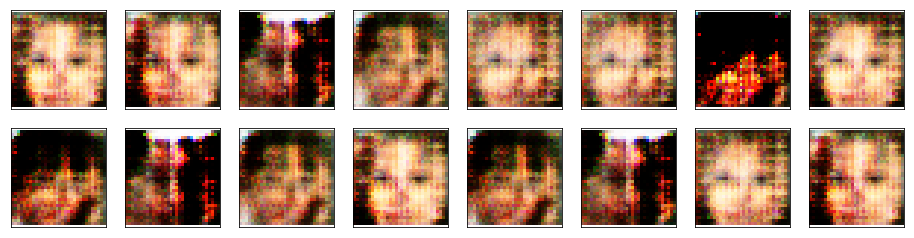

Epoch [    2/   20] | d_loss: 1.3035 | real_loss: 4.6392 | g_loss: 0.2547
Epoch [    2/   20] | d_loss: 0.9003 | real_loss: 3.0225 | g_loss: 0.7566
Epoch [    2/   20] | d_loss: 0.8143 | real_loss: 3.4855 | g_loss: 0.3736
Epoch [    2/   20] | d_loss: 0.9337 | real_loss: 3.3386 | g_loss: 0.5777
Epoch [    2/   20] | d_loss: 0.7992 | real_loss: 1.9631 | g_loss: 0.5814
Epoch [    2/   20] | d_loss: 1.0599 | real_loss: 4.1788 | g_loss: 0.2553
Epoch [    2/   20] | d_loss: 1.4297 | real_loss: 2.0431 | g_loss: 1.2720
Epoch [    2/   20] | d_loss: 1.4929 | real_loss: 1.9460 | g_loss: 0.8507


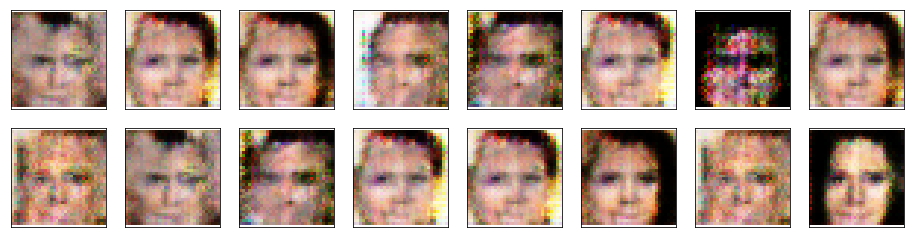

Epoch [    3/   20] | d_loss: 1.2348 | real_loss: 2.9936 | g_loss: 0.4653
Epoch [    3/   20] | d_loss: 1.0994 | real_loss: 2.3961 | g_loss: 0.2629
Epoch [    3/   20] | d_loss: 0.6133 | real_loss: 2.4551 | g_loss: 0.4004
Epoch [    3/   20] | d_loss: 0.7393 | real_loss: 2.5922 | g_loss: 0.2773
Epoch [    3/   20] | d_loss: 1.2795 | real_loss: 1.6426 | g_loss: 0.5522
Epoch [    3/   20] | d_loss: 0.8948 | real_loss: 2.2638 | g_loss: 0.3266
Epoch [    3/   20] | d_loss: 1.0103 | real_loss: 3.2185 | g_loss: 0.5280
Epoch [    3/   20] | d_loss: 1.2823 | real_loss: 1.5565 | g_loss: 1.0658


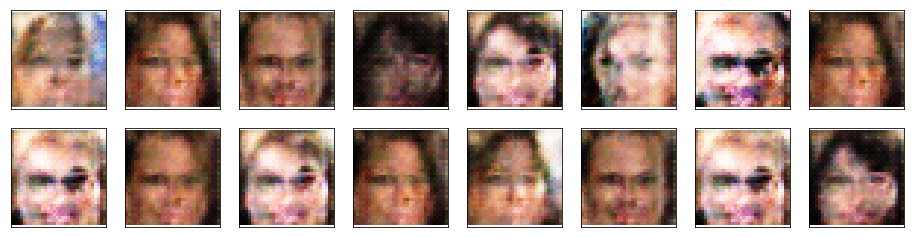

saving....   d_loss:  2.7553534507751465 min_g_loss:  2.795349597930908
Epoch [    4/   20] | d_loss: 2.7554 | real_loss: 2.7953 | g_loss: 0.0994
saving....   d_loss:  1.0265843868255615 min_g_loss:  2.0633912086486816
saving....   d_loss:  1.418174386024475 min_g_loss:  1.4754098653793335
saving....   d_loss:  1.3901280164718628 min_g_loss:  1.302283525466919
saving....   d_loss:  1.0707060098648071 min_g_loss:  1.2997024059295654
saving....   d_loss:  1.489315152168274 min_g_loss:  1.2078508138656616
saving....   d_loss:  1.5228310823440552 min_g_loss:  0.747799813747406
Epoch [    4/   20] | d_loss: 1.0210 | real_loss: 2.2791 | g_loss: 0.5100
Epoch [    4/   20] | d_loss: 1.0873 | real_loss: 5.0247 | g_loss: 0.1305
Epoch [    4/   20] | d_loss: 1.8005 | real_loss: 4.6151 | g_loss: 0.2431
Epoch [    4/   20] | d_loss: 0.7652 | real_loss: 2.4389 | g_loss: 0.3667
Epoch [    4/   20] | d_loss: 1.4322 | real_loss: 1.8085 | g_loss: 1.2906
Epoch [    4/   20] | d_loss: 1.1323 | real_loss: 

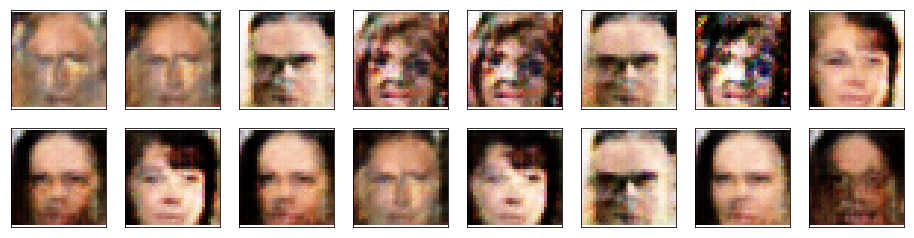

Epoch [    5/   20] | d_loss: 1.4769 | real_loss: 2.9434 | g_loss: 0.2395
Epoch [    5/   20] | d_loss: 0.5837 | real_loss: 2.8415 | g_loss: 0.3752
saving....   d_loss:  1.5287392139434814 min_g_loss:  0.6261525750160217
Epoch [    5/   20] | d_loss: 1.1350 | real_loss: 2.3741 | g_loss: 0.4321
Epoch [    5/   20] | d_loss: 0.7583 | real_loss: 3.3845 | g_loss: 0.3365
Epoch [    5/   20] | d_loss: 1.3776 | real_loss: 1.3944 | g_loss: 1.1520
Epoch [    5/   20] | d_loss: 0.7786 | real_loss: 2.7370 | g_loss: 0.4531
Epoch [    5/   20] | d_loss: 1.2474 | real_loss: 1.4344 | g_loss: 0.7495
Epoch [    5/   20] | d_loss: 1.4088 | real_loss: 1.7396 | g_loss: 0.9293
saving....   d_loss:  1.432485818862915 min_g_loss:  0.5415112972259521


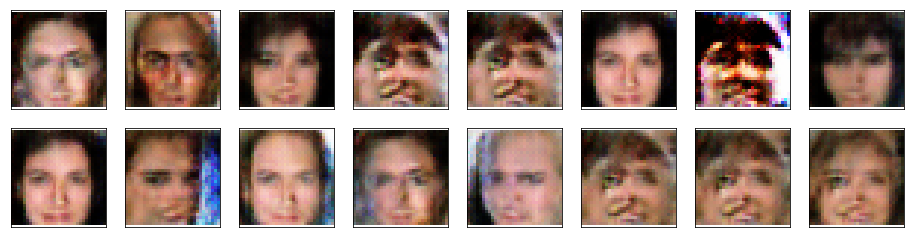

Epoch [    6/   20] | d_loss: 2.4939 | real_loss: 2.4222 | g_loss: 0.1523
Epoch [    6/   20] | d_loss: 1.0756 | real_loss: 2.0807 | g_loss: 0.4899
Epoch [    6/   20] | d_loss: 0.9464 | real_loss: 1.9284 | g_loss: 0.7651
Epoch [    6/   20] | d_loss: 1.0651 | real_loss: 2.9136 | g_loss: 0.8025
Epoch [    6/   20] | d_loss: 1.2667 | real_loss: 2.3031 | g_loss: 0.9567
Epoch [    6/   20] | d_loss: 0.8599 | real_loss: 1.8574 | g_loss: 0.4917
Epoch [    6/   20] | d_loss: 0.8126 | real_loss: 3.1539 | g_loss: 0.3221
Epoch [    6/   20] | d_loss: 0.9319 | real_loss: 3.7948 | g_loss: 0.3140


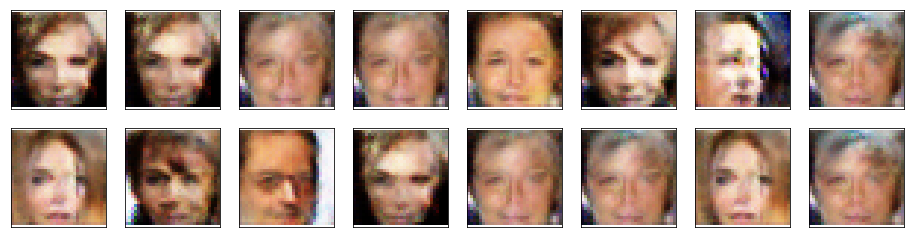

Epoch [    7/   20] | d_loss: 0.9947 | real_loss: 5.2079 | g_loss: 0.0873
Epoch [    7/   20] | d_loss: 1.0007 | real_loss: 2.1009 | g_loss: 0.6766
Epoch [    7/   20] | d_loss: 0.9613 | real_loss: 3.1967 | g_loss: 0.2642
saving....   d_loss:  2.2262518405914307 min_g_loss:  0.2934347093105316
Epoch [    7/   20] | d_loss: 1.0724 | real_loss: 2.5195 | g_loss: 0.6119
Epoch [    7/   20] | d_loss: 1.0494 | real_loss: 1.5246 | g_loss: 0.7090
Epoch [    7/   20] | d_loss: 0.9052 | real_loss: 1.3554 | g_loss: 0.4383
Epoch [    7/   20] | d_loss: 1.0311 | real_loss: 1.6441 | g_loss: 0.5930
Epoch [    7/   20] | d_loss: 1.0650 | real_loss: 2.6637 | g_loss: 0.4669


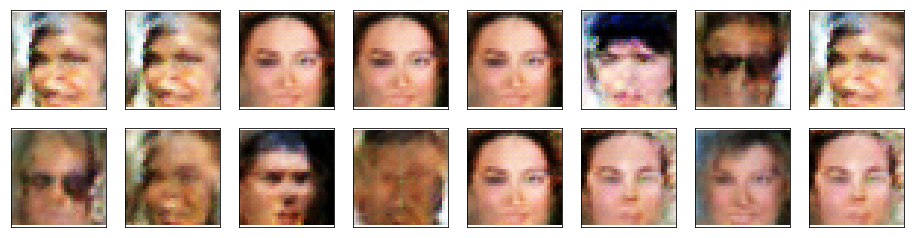

Epoch [    8/   20] | d_loss: 2.1760 | real_loss: 3.2922 | g_loss: 0.0963
Epoch [    8/   20] | d_loss: 0.9208 | real_loss: 2.0291 | g_loss: 0.4715
Epoch [    8/   20] | d_loss: 1.2459 | real_loss: 2.7568 | g_loss: 0.2342
Epoch [    8/   20] | d_loss: 1.0214 | real_loss: 2.0857 | g_loss: 0.3310
Epoch [    8/   20] | d_loss: 1.1937 | real_loss: 1.7627 | g_loss: 0.4749
Epoch [    8/   20] | d_loss: 0.8881 | real_loss: 2.1183 | g_loss: 0.2199
Epoch [    8/   20] | d_loss: 1.0786 | real_loss: 2.3742 | g_loss: 0.6088
Epoch [    8/   20] | d_loss: 0.9033 | real_loss: 2.8784 | g_loss: 0.4296


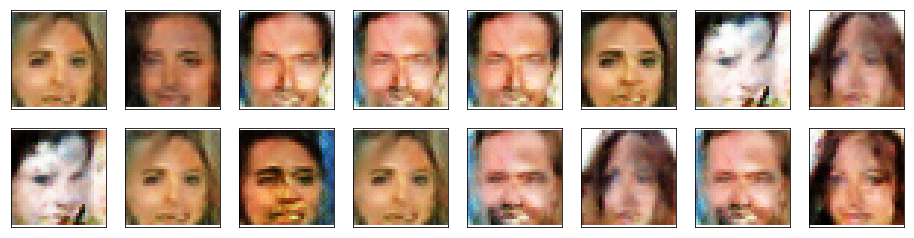

Epoch [    9/   20] | d_loss: 2.0398 | real_loss: 3.6354 | g_loss: 0.3804
Epoch [    9/   20] | d_loss: 0.7336 | real_loss: 2.1081 | g_loss: 0.5355
Epoch [    9/   20] | d_loss: 1.2768 | real_loss: 3.3835 | g_loss: 0.2392
Epoch [    9/   20] | d_loss: 0.8920 | real_loss: 2.1642 | g_loss: 0.4261
Epoch [    9/   20] | d_loss: 0.7965 | real_loss: 1.5787 | g_loss: 0.6685
Epoch [    9/   20] | d_loss: 1.1305 | real_loss: 1.8434 | g_loss: 0.6563
Epoch [    9/   20] | d_loss: 1.1763 | real_loss: 2.2369 | g_loss: 1.0081
Epoch [    9/   20] | d_loss: 1.1503 | real_loss: 1.7590 | g_loss: 0.8073


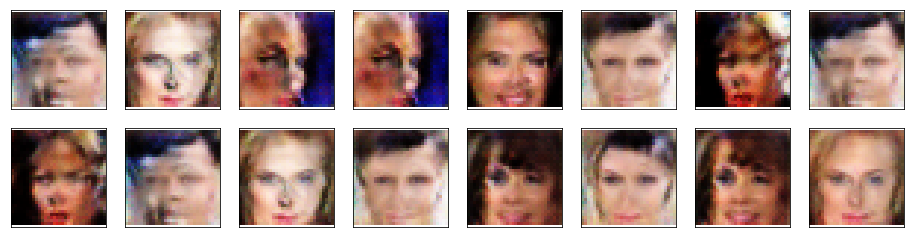

Epoch [   10/   20] | d_loss: 1.9210 | real_loss: 2.8610 | g_loss: 0.0724
Epoch [   10/   20] | d_loss: 1.2444 | real_loss: 1.6809 | g_loss: 0.7191
Epoch [   10/   20] | d_loss: 0.9812 | real_loss: 1.2525 | g_loss: 0.7826
Epoch [   10/   20] | d_loss: 1.3821 | real_loss: 3.1190 | g_loss: 0.1855
Epoch [   10/   20] | d_loss: 1.1829 | real_loss: 1.3548 | g_loss: 0.9563
Epoch [   10/   20] | d_loss: 1.2728 | real_loss: 3.2112 | g_loss: 0.3262
Epoch [   10/   20] | d_loss: 1.1169 | real_loss: 2.5354 | g_loss: 0.5234
Epoch [   10/   20] | d_loss: 1.4642 | real_loss: 1.6960 | g_loss: 0.7670


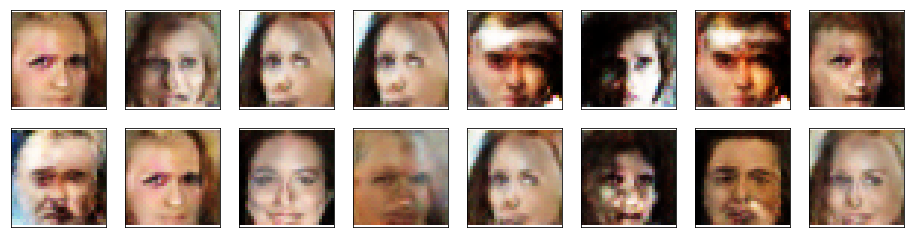

Epoch [   11/   20] | d_loss: 1.2391 | real_loss: 2.0454 | g_loss: 0.1601
Epoch [   11/   20] | d_loss: 0.9935 | real_loss: 2.4571 | g_loss: 0.2821
Epoch [   11/   20] | d_loss: 1.2008 | real_loss: 2.4633 | g_loss: 0.2217
Epoch [   11/   20] | d_loss: 1.1692 | real_loss: 2.1460 | g_loss: 0.9810
Epoch [   11/   20] | d_loss: 1.0349 | real_loss: 2.0329 | g_loss: 0.6244
Epoch [   11/   20] | d_loss: 1.1992 | real_loss: 1.6268 | g_loss: 0.7506
Epoch [   11/   20] | d_loss: 1.2075 | real_loss: 2.6388 | g_loss: 0.5063
Epoch [   11/   20] | d_loss: 0.8297 | real_loss: 2.7179 | g_loss: 0.2065


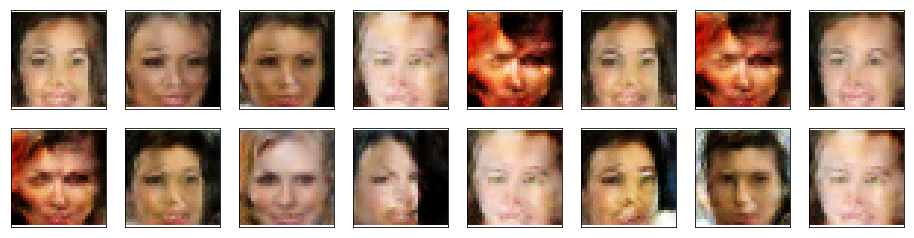

Epoch [   12/   20] | d_loss: 2.6383 | real_loss: 3.3807 | g_loss: 0.0840
Epoch [   12/   20] | d_loss: 1.0184 | real_loss: 1.8204 | g_loss: 0.7713
Epoch [   12/   20] | d_loss: 0.8654 | real_loss: 2.2871 | g_loss: 0.4653
Epoch [   12/   20] | d_loss: 0.9780 | real_loss: 2.0105 | g_loss: 0.7389
Epoch [   12/   20] | d_loss: 0.3615 | real_loss: 3.6818 | g_loss: 0.1036
Epoch [   12/   20] | d_loss: 0.8701 | real_loss: 1.7433 | g_loss: 0.5732
Epoch [   12/   20] | d_loss: 1.6639 | real_loss: 1.0647 | g_loss: 1.4603
Epoch [   12/   20] | d_loss: 1.6065 | real_loss: 2.9410 | g_loss: 0.1869


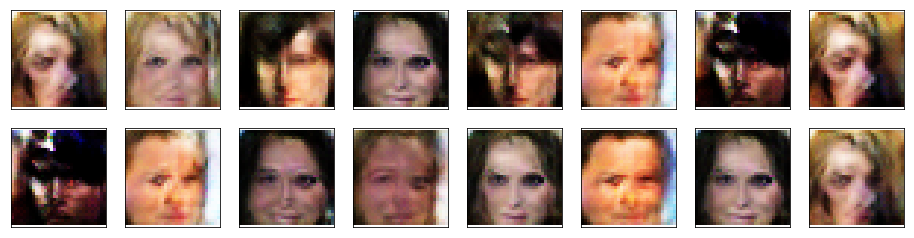

Epoch [   13/   20] | d_loss: 2.3904 | real_loss: 3.1380 | g_loss: 0.0366
Epoch [   13/   20] | d_loss: 0.7889 | real_loss: 2.2631 | g_loss: 0.4564
Epoch [   13/   20] | d_loss: 0.8861 | real_loss: 2.4511 | g_loss: 0.5535
Epoch [   13/   20] | d_loss: 1.0762 | real_loss: 2.3805 | g_loss: 0.6345
Epoch [   13/   20] | d_loss: 0.7954 | real_loss: 1.7619 | g_loss: 0.5949
Epoch [   13/   20] | d_loss: 1.4154 | real_loss: 1.6922 | g_loss: 0.5254
Epoch [   13/   20] | d_loss: 1.0346 | real_loss: 1.4276 | g_loss: 0.8283
Epoch [   13/   20] | d_loss: 1.3115 | real_loss: 2.9353 | g_loss: 0.6248


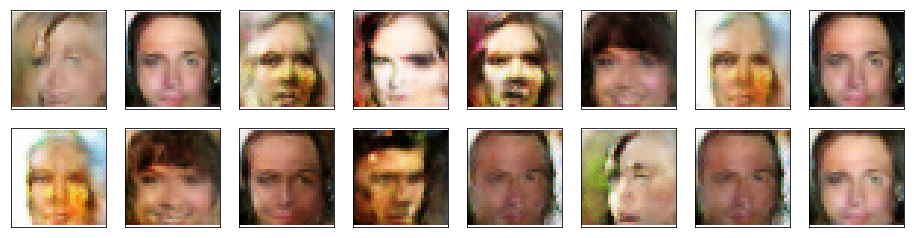

Epoch [   14/   20] | d_loss: 2.1709 | real_loss: 1.5900 | g_loss: 0.1828
Epoch [   14/   20] | d_loss: 0.6970 | real_loss: 1.8066 | g_loss: 0.5051
Epoch [   14/   20] | d_loss: 1.3251 | real_loss: 2.2555 | g_loss: 0.3832
Epoch [   14/   20] | d_loss: 1.1249 | real_loss: 1.4613 | g_loss: 0.7714
Epoch [   14/   20] | d_loss: 1.0873 | real_loss: 2.2555 | g_loss: 0.3740
Epoch [   14/   20] | d_loss: 0.6185 | real_loss: 2.6752 | g_loss: 0.2682
Epoch [   14/   20] | d_loss: 0.6857 | real_loss: 2.2295 | g_loss: 0.5436
Epoch [   14/   20] | d_loss: 0.9647 | real_loss: 1.6456 | g_loss: 0.8038


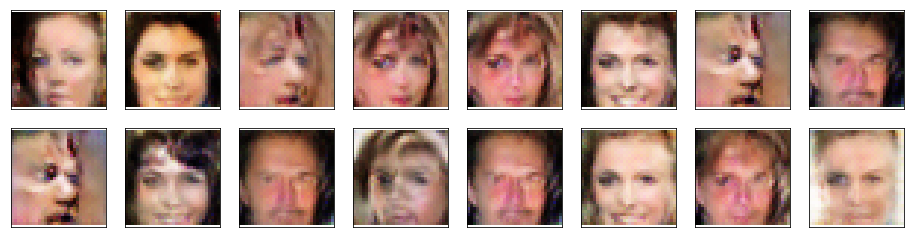

Epoch [   15/   20] | d_loss: 1.8608 | real_loss: 2.4941 | g_loss: 0.3197
Epoch [   15/   20] | d_loss: 0.8955 | real_loss: 1.3083 | g_loss: 0.7274
Epoch [   15/   20] | d_loss: 0.6198 | real_loss: 2.0875 | g_loss: 0.2015
saving....   d_loss:  2.0098934173583984 min_g_loss:  0.20758052170276642
Epoch [   15/   20] | d_loss: 1.0500 | real_loss: 1.0012 | g_loss: 0.7557
Epoch [   15/   20] | d_loss: 0.9418 | real_loss: 4.2393 | g_loss: 0.1869
Epoch [   15/   20] | d_loss: 0.5225 | real_loss: 1.9781 | g_loss: 0.2004
Epoch [   15/   20] | d_loss: 1.8710 | real_loss: 4.5291 | g_loss: 0.3704
Epoch [   15/   20] | d_loss: 1.4896 | real_loss: 3.4979 | g_loss: 0.0858


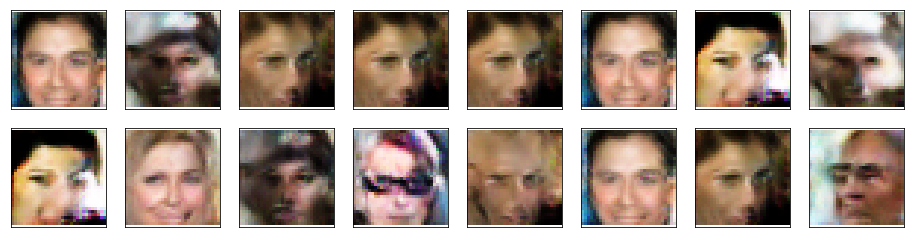

Epoch [   16/   20] | d_loss: 1.7529 | real_loss: 2.3466 | g_loss: 0.0371
Epoch [   16/   20] | d_loss: 0.5199 | real_loss: 3.8574 | g_loss: 0.1739
Epoch [   16/   20] | d_loss: 0.7382 | real_loss: 2.7040 | g_loss: 0.5724
Epoch [   16/   20] | d_loss: 1.1268 | real_loss: 1.8003 | g_loss: 0.6418
Epoch [   16/   20] | d_loss: 0.8515 | real_loss: 3.6418 | g_loss: 0.1696
Epoch [   16/   20] | d_loss: 0.9807 | real_loss: 2.9532 | g_loss: 0.7079
Epoch [   16/   20] | d_loss: 0.9353 | real_loss: 2.2772 | g_loss: 0.5723
Epoch [   16/   20] | d_loss: 0.7506 | real_loss: 1.6281 | g_loss: 0.5323


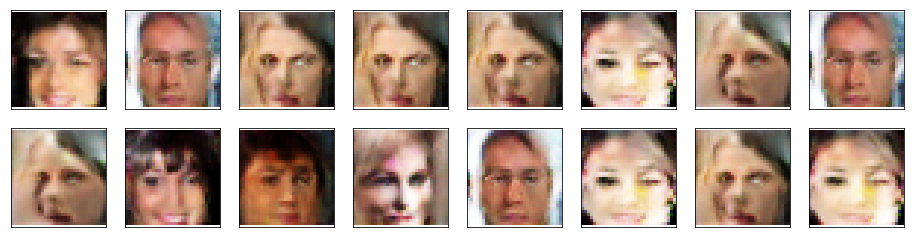

Epoch [   17/   20] | d_loss: 1.0309 | real_loss: 2.7788 | g_loss: 0.1137
Epoch [   17/   20] | d_loss: 0.3807 | real_loss: 3.8233 | g_loss: 0.1934
Epoch [   17/   20] | d_loss: 0.7570 | real_loss: 3.3170 | g_loss: 0.4392
Epoch [   17/   20] | d_loss: 0.6225 | real_loss: 2.9604 | g_loss: 0.4733
Epoch [   17/   20] | d_loss: 0.9411 | real_loss: 1.6622 | g_loss: 0.6249
Epoch [   17/   20] | d_loss: 0.6249 | real_loss: 1.6803 | g_loss: 0.3402
Epoch [   17/   20] | d_loss: 1.0217 | real_loss: 5.2825 | g_loss: 0.1141
Epoch [   17/   20] | d_loss: 0.3125 | real_loss: 1.9887 | g_loss: 0.2243


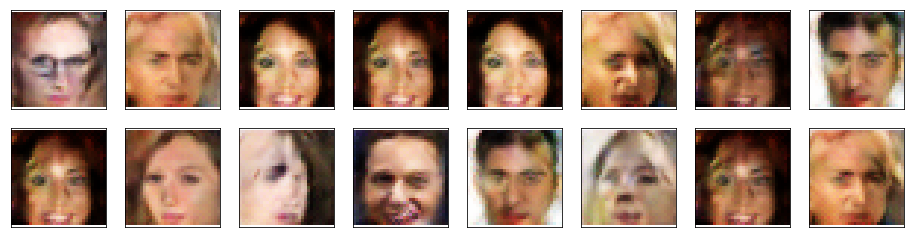

Epoch [   18/   20] | d_loss: 1.5793 | real_loss: 3.2588 | g_loss: 0.0229
Epoch [   18/   20] | d_loss: 0.6252 | real_loss: 1.4129 | g_loss: 0.4462
Epoch [   18/   20] | d_loss: 0.9483 | real_loss: 2.4176 | g_loss: 0.5109
Epoch [   18/   20] | d_loss: 0.9912 | real_loss: 2.3646 | g_loss: 0.7322
saving....   d_loss:  1.240010380744934 min_g_loss:  0.19588808715343475
Epoch [   18/   20] | d_loss: 0.5075 | real_loss: 2.6827 | g_loss: 0.1832
Epoch [   18/   20] | d_loss: 0.4941 | real_loss: 2.5332 | g_loss: 0.3121
Epoch [   18/   20] | d_loss: 0.8168 | real_loss: 2.6940 | g_loss: 0.4202
Epoch [   18/   20] | d_loss: 0.8292 | real_loss: 2.9417 | g_loss: 0.2107


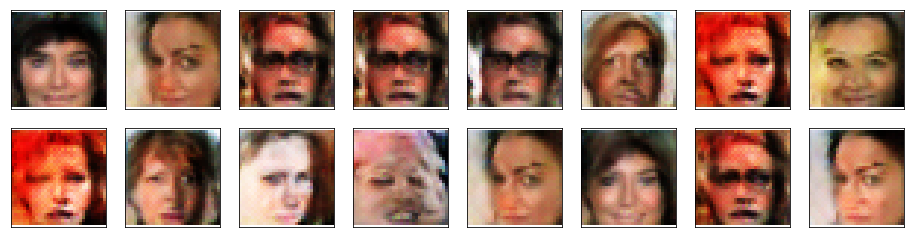

Epoch [   19/   20] | d_loss: 4.2963 | real_loss: 1.5140 | g_loss: 0.0919
Epoch [   19/   20] | d_loss: 0.8550 | real_loss: 2.2190 | g_loss: 0.1626
Epoch [   19/   20] | d_loss: 0.8549 | real_loss: 3.3336 | g_loss: 0.3099
Epoch [   19/   20] | d_loss: 1.1170 | real_loss: 4.3229 | g_loss: 0.0846
Epoch [   19/   20] | d_loss: 1.3660 | real_loss: 3.5435 | g_loss: 0.3589
Epoch [   19/   20] | d_loss: 0.3898 | real_loss: 3.3583 | g_loss: 0.2636
Epoch [   19/   20] | d_loss: 0.5644 | real_loss: 2.9827 | g_loss: 0.1555
Epoch [   19/   20] | d_loss: 0.6023 | real_loss: 2.7245 | g_loss: 0.1530


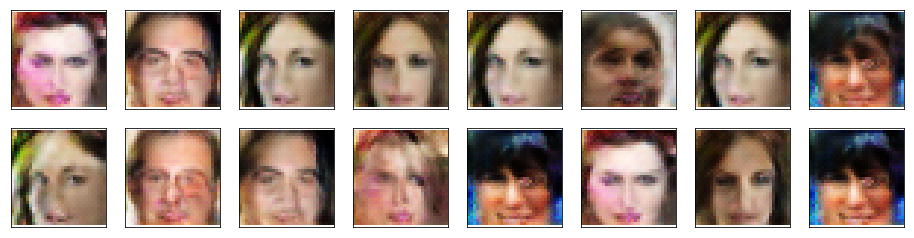

Epoch [   20/   20] | d_loss: 5.4597 | real_loss: 0.8895 | g_loss: 0.0063
Epoch [   20/   20] | d_loss: 0.9016 | real_loss: 3.3505 | g_loss: 0.2180
Epoch [   20/   20] | d_loss: 0.8116 | real_loss: 5.5626 | g_loss: 0.1292
Epoch [   20/   20] | d_loss: 0.5593 | real_loss: 2.5864 | g_loss: 0.4700
Epoch [   20/   20] | d_loss: 0.5856 | real_loss: 1.2309 | g_loss: 0.3560
Epoch [   20/   20] | d_loss: 0.4939 | real_loss: 1.5804 | g_loss: 0.3376
Epoch [   20/   20] | d_loss: 0.5393 | real_loss: 3.5785 | g_loss: 0.0321
Epoch [   20/   20] | d_loss: 1.5133 | real_loss: 4.0777 | g_loss: 0.0744


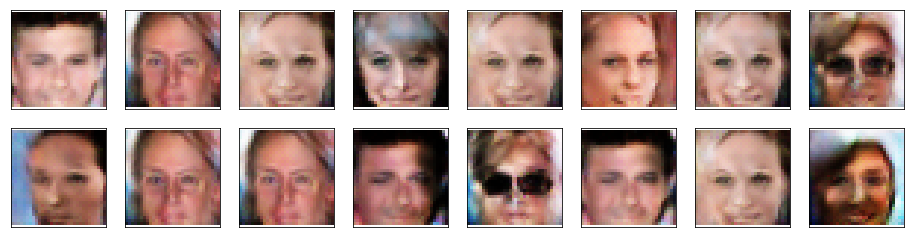

Generator(
  (fc): Linear(in_features=100, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=2048, bias=True)
  (deconv): Sequential(
    (0): ConvTranspose2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (deconv_1): Sequential(
    (0): ConvTranspose2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (deconv0): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (deconv0_1): Sequential(
    (0): ConvTranspose2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 

In [51]:
# set number of epochs 
n_epochs = 20
from workspace_util import active_session

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
# call training function
with active_session():
    losses = train(D, G, n_epochs=n_epochs)
G.load_state_dict(torch.load('Generator.pt'))
G.eval()

## Training loss

Plot the training losses for the generator and discriminator, recorded after each epoch.

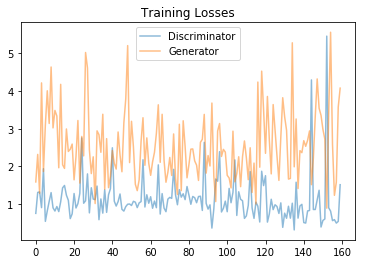

In [52]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

## Generator samples from training

View samples of images from the generator, and answer a question about the strengths and weaknesses of your trained models.

In [53]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

In [54]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

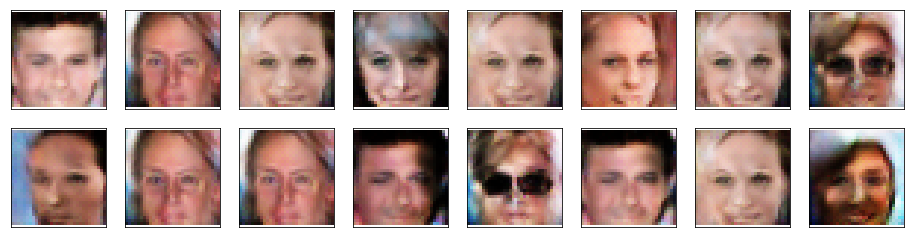

In [55]:
_ = view_samples(-1, samples)

### Question: What do you notice about your generated samples and how might you improve this model?
When you answer this question, consider the following factors:
* The dataset is biased; it is made of "celebrity" faces that are mostly white
* Model size; larger models have the opportunity to learn more features in a data feature space
* Optimization strategy; optimizers and number of epochs affect your final result


**Answer:** 

While training this model I noticed couple strange things. First is that smaller generator's loss doesn't mean better quality of an image. I tried models with a lot more layers with different structures including risidual blocks, and while both generator's and discriminator's losses were much smaller, the pictures looked a lot worse. I tried all kinds of different hyperparameters and nothing really seems to produce better pictures. The only parameter I would change if I could is the image size for both dicriminator's input and generator's output.

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "problem_unittests.py" files in your submission.